In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
import matplotlib.tri as tri

import sys
import os

sys.path.append("../../code")

import sparseRRR
from plot_utils import adjust_spines

### Load observed data
Load the summary statistics of raw membrane voltage recordings generated with `../code/preprocess.ipynb`.

In [2]:
V1_25degree = pickle.load(open('../../code/pickles/V1_features.pickle', 'rb'))
ephys_features = np.array(V1_25degree['X_o'].columns)[:-1]
Xo = V1_25degree['X_o'].copy()
V1_names = V1_25degree['V1_names']

In [3]:
v1_meta = pd.read_csv('../../data/Gouwens (2020)/20200625_patchseq_metadata_mouse.csv')
v1_meta = v1_meta.set_index('ephys_session_id')
v1_meta = v1_meta.reindex(Xo.index.astype('int64'))
celltypes = v1_meta['corresponding_AIT2.3.1_alias']
v1_meta.shape

(4107, 21)

In [4]:
celltype_Vip, celltype_Sst, celltype_Lamp5, celltype_Pvalb, celltype_Sncg, celltype_Serpinf1 = \
    [False]*celltypes.shape[0], [False]*celltypes.shape[0], [False]*celltypes.shape[0], \
        [False]*celltypes.shape[0], [False]*celltypes.shape[0], [False]*celltypes.shape[0]

for i, ct in enumerate(celltypes):
    if isinstance(ct, str):
        if ct.split(' ')[0]=='Vip':
            celltype_Vip[i]=True
        elif ct.split(' ')[0]=='Sst':
            celltype_Sst[i]=True
        elif ct.split(' ')[0]=='Lamp5':
            celltype_Lamp5[i]=True
        elif ct.split(' ')[0]=='Pvalb':
            celltype_Pvalb[i]=True
        elif ct.split(' ')[0]=='Sncg':
            celltype_Sncg[i]=True
        elif ct.split(' ')[0]=='Serpinf1':
            celltype_Serpinf1[i]=True

In [5]:
ttypes_tasic = np.load('../../data/Gouwens (2020)/tasic-ttypes.npy')
colors_tasic = np.load('../../data/Gouwens (2020)/tasic-colors.npy')
color_map = {}
for c_type in np.unique(ttypes_tasic):
    color_map.update({c_type:colors_tasic[np.where(ttypes_tasic==c_type)[0][0]]})
colors = np.array([
    color_map[c_type] if c_type in ttypes_tasic else 'black' for c_type in celltypes
])

In [6]:
v1_genes = pd.read_csv('../../data/Gouwens (2020)/20200513_Mouse_PatchSeq_Release_count.csv')
v1_genes=v1_genes.set_index('Unnamed: 0').T
v1_genes=v1_genes.reindex(v1_meta['transcriptomics_sample_id'].values)
gene_names = v1_genes.columns.values
v1_genes.shape

(4107, 45768)

In [7]:
model_param_names = np.array(['C', r'$R_{input}$', r'$\tau$', r'$g_{Nat}$', r'$g_{Na}$', r'$g_{Kd}$', r'$g_{M}$',
                         r'$g_{Kv31}$', r'$g_{L}$', r'$E_{leak}$', r'$\tau_{max}$', 'VT', r'$r_{SS}$', 'I'])
prior_min = [0.1,  20,  0.1,    0,        0,      0,      0,      0,      0, -130,    50,    -90,   0.1,   20]
prior_max = [15,   1000,   70,   250,     100,      30,    3,     250,     3,  -50,  4000,   -35,    3,   870]

### Figure 6 and 7

We used sparse reduced-rank regression to predict model parameters from gene expression levels.

In [8]:
ttypes = []
for c_type in celltypes.unique():
    if not isinstance(c_type, str):
        continue
    if c_type.split(' ')[0]=='Lamp5':
        ttypes.append(c_type)
for c_type in celltypes.unique():
    if not isinstance(c_type, str):
        continue
    if c_type.split(' ')[0]=='Sncg':
        ttypes.append(c_type)
for c_type in celltypes.unique():
    if not isinstance(c_type, str):
        continue
    if c_type.split(' ')[0]=='Vip':
        ttypes.append(c_type)
for c_type in celltypes.unique():
    if not isinstance(c_type, str):
        continue
    if c_type.split(' ')[0]=='Sst':
        ttypes.append(c_type)
for c_type in celltypes.unique():
    if not isinstance(c_type, str):
        continue
    if c_type.split(' ')[0]=='Pvalb':
        ttypes.append(c_type)
for c_type in celltypes.unique():
    if not isinstance(c_type, str):
        continue
    if c_type.split(' ')[0]=='Serpinf1':
        ttypes.append(c_type)

In [9]:
fav_tr_schedule = "2d"

In [10]:
with open(
    "../../code/save_model_parameters/V1/training_schedule_{}.pickle".format(fav_tr_schedule),
    "rb",
) as f:
    THETA = pickle.load(f)
highest_posterior_samples = np.concatenate(
    [
        THETA["highest posterior samples"][cell]
        if cell in THETA["highest posterior samples"]
        else np.ones((13,)) * np.nan
        for cell in Xo.index
    ]
).reshape((Xo.shape[0], len(model_param_names)))

In [11]:
highest_posterior_samples_standardized = (
    highest_posterior_samples - highest_posterior_samples.mean(axis=0)
) / highest_posterior_samples.std(axis=0)
family_av_model_params = np.array(
    [
        highest_posterior_samples_standardized[family, :].mean(axis=0)
        for family in [
            celltype_Lamp5,
            celltype_Sncg,
            celltype_Vip,
            celltype_Sst,
            celltype_Pvalb,
            celltype_Serpinf1,
        ]
    ]
)
df_family = pd.DataFrame(
    data=family_av_model_params.T,
    index=model_param_names,
    columns=["Lamp5", "Sncg", "Vip", "Sst", "Pvalb", "Serpinf1"],
)
df_family

,Lamp5,Sncg,Vip,Sst,Pvalb,Serpinf1
C,1.020321,0.293427,0.223609,-0.135218,-0.601481,-0.096141
$R_{input}$,-0.398506,-0.109800,0.336786,-0.029031,0.129071,-0.155225
$\tau$,0.567706,-0.411972,-0.123376,-0.099382,0.060559,-0.175992
$g_{Nat}$,-0.172405,-0.155531,-0.038794,0.191717,-0.190880,0.137281
$g_{Na}$,0.228821,0.317614,0.081710,-0.185828,-0.119300,-0.170602
$g_{Kd}$,0.171812,-0.474411,-0.319622,-0.255058,0.846083,-0.392991
$g_{M}$,-0.735041,0.441620,0.660968,0.011470,-0.208570,0.528603
$g_{Kv31}$,0.206538,-0.641592,-0.495613,0.051368,0.544849,-0.407014
$g_{L}$,-0.357145,-0.397992,-0.310131,0.098420,0.379829,-0.181798
$E_{leak}$,-0.409175,0.274051,0.029396,0.303844,-0.329576,0.129376


In [12]:
real_family_av_model_params = np.array(
    [
        highest_posterior_samples[family, :].mean(axis=0)
        for family in [
            celltype_Lamp5,
            celltype_Sncg,
            celltype_Vip,
            celltype_Sst,
            celltype_Pvalb,
            celltype_Serpinf1,
        ]
    ]
)
real_df_family = pd.DataFrame(
    data=real_family_av_model_params.T,
    index=model_param_names,
    columns=["Lamp5", "Sncg", "Vip", "Sst", "Pvalb", "Serpinf1"],
)
real_df_family

,Lamp5,Sncg,Vip,Sst,Pvalb,Serpinf1
C,7.949274,6.221280,6.055301,5.202295,4.093871,5.295186
$R_{input}$,445.041840,483.454803,542.874329,494.201752,515.237427,477.411011
$\tau$,51.834976,36.370174,40.925819,41.304604,43.829357,40.095253
$g_{Nat}$,153.688690,154.657700,161.360809,174.596512,152.627991,171.470856
$g_{Na}$,40.524250,42.554363,37.160839,31.044081,32.565094,31.392174
$g_{Kd}$,13.590534,10.208534,11.018611,11.356516,17.119331,10.634642
$g_{M}$,0.956247,1.758525,1.908081,1.465237,1.315207,1.817832
$g_{Kv31}$,110.317955,70.133591,77.050041,102.965965,126.347145,81.247925
$g_{L}$,0.705426,0.682262,0.732088,0.963776,1.123362,0.804865
$E_{leak}$,-79.512543,-72.962433,-75.307953,-72.676743,-78.749397,-74.349411


In [13]:
family_av_model_params = np.array(
    [
        highest_posterior_samples_standardized[celltypes.values == ttype, :].mean(
            axis=0
        )
        for ttype in ttypes
    ]
)
df_ttype = pd.DataFrame(
    data=family_av_model_params.T, index=model_param_names, columns=ttypes
)
df_ttype

,Lamp5 Plch2 Dock5,Lamp5 Lsp1,Lamp5 Fam19a1 Pax6,Lamp5 Ntn1 Npy2r,Lamp5 Krt73,Lamp5 Fam19a1 Tmem182,Lamp5 Lhx6,Sncg Vip Itih5,Sncg Slc17a8,Sncg Vip Nptx2,...,Pvalb Th Sst,Pvalb Tpbg,Pvalb Reln Itm2a,Pvalb Calb1 Sst,Pvalb Gabrg1,Pvalb Akr1c18 Ntf3,Pvalb Gpr149 Islr,Pvalb Vipr2,Serpinf1 Clrn1,Serpinf1 Aqp5 Vip
C,1.208630,1.096114,0.665677,0.789928,0.087636,1.123183,0.135483,0.249202,0.353927,0.410707,...,-0.415008,-0.485166,-0.597833,-0.322150,-0.442715,-0.805711,-0.835089,-0.159389,-0.159499,-0.073102
$R_{input}$,-0.178209,-0.687795,-0.770578,-0.205590,0.074738,-0.112628,-0.484863,-0.152609,-0.614021,0.339806,...,0.179856,-0.033851,0.143044,0.433591,0.203814,-0.178480,0.183165,0.071396,-0.092619,-0.177990
$\tau$,0.506273,0.729633,-0.738506,0.414050,0.088520,0.550248,0.759189,-0.358917,-0.796723,-0.282716,...,0.026711,0.525938,0.005914,-0.022936,0.222023,-0.055819,-0.217741,0.273836,0.012208,-0.244429
$g_{Nat}$,-0.119870,-0.364538,-0.281841,0.060417,0.252280,0.060443,-0.017842,-0.197700,0.168825,-0.317700,...,-0.288909,0.391992,-0.155712,-0.704868,-0.142053,-0.188770,-0.835947,0.281585,-0.058347,0.208418
$g_{Na}$,0.259453,0.278599,0.429388,0.062826,-0.026970,0.346862,0.067845,0.337630,0.140975,0.259044,...,-0.256038,0.054628,0.019717,0.083377,-0.441605,-0.350570,-0.485740,0.265142,-0.171161,-0.170399
$g_{Kd}$,-0.042737,0.513426,-0.978951,-0.084874,-0.206875,-0.283643,0.566520,-0.472793,-0.653012,-0.288536,...,0.754222,0.740371,0.793392,0.748271,1.315561,0.877768,1.011260,0.474578,-0.147939,-0.482100
$g_{M}$,-0.580045,-1.114094,0.429350,-0.380312,-0.390181,0.108083,-1.039796,0.544246,0.453047,0.493141,...,0.023769,-0.817126,-0.183107,-0.131062,-0.850841,-0.090805,0.006833,0.087621,0.354043,0.592079
$g_{Kv31}$,0.191155,0.330527,-0.898220,0.174361,0.085417,-0.075661,-0.050960,-0.761137,-0.548496,-0.367728,...,0.695346,0.581919,0.493499,0.568716,0.852042,0.481573,0.907347,-0.119989,-0.428743,-0.399112
$g_{L}$,-0.458899,-0.273581,-0.444617,-0.428914,0.095674,-0.549699,-0.105820,-0.438524,-0.126392,-0.451413,...,0.337330,0.452789,0.300766,-0.010506,0.161377,0.643514,0.520617,-0.060116,-0.372485,-0.112458
$E_{leak}$,-0.340333,-0.485079,0.133209,-0.528321,-0.291125,-0.177183,-0.246870,0.180958,0.208900,0.239479,...,-0.160109,-0.681484,-0.288180,-0.288341,-0.223021,-0.479797,-0.245724,-0.193734,0.125933,0.130628


We load the gene expression levels again but this time keep the ion channel and marker genes. 

In [14]:
original_gene_names = np.array(v1_genes.columns)
IonChannelGenes = pd.read_csv(
    "../../data/GO_term_summary_20211104_075621.txt", header=0, sep="\t"
)
selectedGenes = np.array(
    [
        (gene in IonChannelGenes["MGI Gene/Marker ID"].values)
        | (
            gene
            in [
                "Pvalb",
                "Lamp5",
                "Vip",
                "Sst",
            ]
        )
        for gene in v1_genes.columns
    ]
)
enough_counts = np.sum(v1_genes, axis=0) >= 10
data_exons = v1_genes.loc[:,selectedGenes & enough_counts]
exonCounts = data_exons.values
gene_names = original_gene_names[selectedGenes & enough_counts]

In [15]:
non_nans = ~np.isnan(exonCounts.sum(axis=1))
exonCounts = exonCounts[non_nans,:]
exonCounts.shape

(3559, 420)

Further preprocessing for genes (gene selection, library size normalization and Z-scoring)

In [16]:
genes = exonCounts.copy()
genes = (
    genes
    / np.sum(genes, axis=1, keepdims=True)
    * np.median(np.sum(genes, axis=1, keepdims=True))
)
genes = np.log2(genes + 1)
genes = genes - np.mean(genes, axis=0)
genes = genes / np.std(genes, axis=0)
G = genes.astype("float64")

Depending on your machine, you might get slightly different weights. To produce the exact same embedding run the code in the 2nd block below.

In [17]:
# recompute if you want
w, v = sparseRRR.relaxed_elastic_rrr(
    G,
    highest_posterior_samples_standardized.astype(np.float64)[non_nans,:],
    rank=2,
    alpha=0.15,
    l1_ratio=1,
)
# save weights
np.savez('./embedding_coordinates/sRRR.npz',
     w=w,
     v=v
    )

In [18]:
# load weights
w = np.load("./embedding_coordinates/sRRR.npz")["w"]
v = np.load("./embedding_coordinates/sRRR.npz")["v"]

print("Genes selected: {}".format(np.sum(w[:, 0] != 0)))

Genes selected: 25


In [19]:
sum(w.sum(axis=1)!=0)

25

In [20]:
# genes selected:
print('Genes selected: ', gene_names[w.sum(axis=1)!=0])

Genes selected:  ['Ano4' 'Cacna1e' 'Cacna2d1' 'Cacna2d2' 'Cacna2d3' 'Gabrb2' 'Gabrd'
 'Grid2' 'Itpr1' 'Kcnab3' 'Kcnc2' 'Kcnc4' 'Kcnd3' 'Kcnh7' 'Kcnn3' 'Kcns3'
 'Kcnt2' 'Lamp5' 'Lrrc38' 'Pvalb' 'Scn3b' 'Slc24a4' 'Trpc5' 'Trpm3' 'Vip']


In [21]:
ttype_av_model_params_sRRR = np.array(
    [(G @ w @ v.T)[celltypes.values[non_nans] == ttype, :].mean(axis=0) for ttype in ttypes]
)
df_ttype_sRRR = pd.DataFrame(
    data=ttype_av_model_params_sRRR.T, index=model_param_names, columns=ttypes
)
df_ttype_sRRR

/var/folders/j9/6j6_y95j0tl4lmss_d5lyv3w0000gn/T/ipykernel_9791/198524594.py:2: RuntimeWarning: Mean of empty slice.
  [(G @ w @ v.T)[celltypes.values[non_nans] == ttype, :].mean(axis=0) for ttype in ttypes]
/Users/yvesbernaerts/Documents/PhD/hh_sbi/hh_sbi_env/lib/python3.9/site-packages/numpy/core/_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


,Lamp5 Plch2 Dock5,Lamp5 Lsp1,Lamp5 Fam19a1 Pax6,Lamp5 Ntn1 Npy2r,Lamp5 Krt73,Lamp5 Fam19a1 Tmem182,Lamp5 Lhx6,Sncg Vip Itih5,Sncg Slc17a8,Sncg Vip Nptx2,...,Pvalb Th Sst,Pvalb Tpbg,Pvalb Reln Itm2a,Pvalb Calb1 Sst,Pvalb Gabrg1,Pvalb Akr1c18 Ntf3,Pvalb Gpr149 Islr,Pvalb Vipr2,Serpinf1 Clrn1,Serpinf1 Aqp5 Vip
C,0.713963,0.753406,0.549128,0.655240,0.232383,0.564244,0.600668,0.362995,0.331397,0.354520,...,-0.478050,-0.467900,-0.593892,-0.457806,-0.513212,-0.714350,-0.676417,-0.226034,0.257771,0.309122
$R_{input}$,-0.372894,-0.438598,-0.221104,-0.300235,-0.206620,-0.242152,-0.376170,-0.008666,-0.083653,0.024364,...,0.075388,-0.006373,0.045029,0.049306,0.075828,0.122748,0.106175,-0.000288,-0.045757,-0.024581
$\tau$,0.466465,0.581408,0.228875,0.345080,0.320375,0.264757,0.515912,-0.120544,0.039699,-0.182633,...,0.032264,0.190066,0.136224,0.076154,0.044731,0.028251,0.046632,0.086300,-0.007300,-0.068645
$g_{Nat}$,-0.111353,-0.148342,-0.040725,-0.073485,-0.094530,-0.052075,-0.136380,0.067085,0.009460,0.087964,...,-0.044608,-0.098468,-0.088664,-0.058369,-0.051379,-0.059754,-0.063456,-0.045660,0.020561,0.045368
$g_{Na}$,0.464883,0.514037,0.323363,0.404795,0.195676,0.340051,0.423612,0.142204,0.169242,0.121801,...,-0.220570,-0.174171,-0.248714,-0.199318,-0.234137,-0.334852,-0.311838,-0.085591,0.121592,0.130051
$g_{Kd}$,0.100191,0.235713,-0.112288,-0.029065,0.278302,-0.072259,0.264270,-0.470485,-0.211241,-0.554109,...,0.435230,0.657014,0.680841,0.482769,0.481957,0.621266,0.617257,0.309349,-0.219963,-0.351085
$g_{M}$,-0.677760,-0.862523,-0.306687,-0.484863,-0.499054,-0.363999,-0.774188,0.246366,-0.022477,0.347839,...,-0.115488,-0.374867,-0.302306,-0.185363,-0.140658,-0.139596,-0.165028,-0.171976,0.045592,0.153618
$g_{Kv31}$,-0.057412,0.033157,-0.180706,-0.139960,0.158495,-0.154584,0.081490,-0.405217,-0.212524,-0.463984,...,0.400688,0.558785,0.598850,0.431294,0.440771,0.577764,0.567984,0.264139,-0.205442,-0.309327
$g_{L}$,-0.279575,-0.265547,-0.257961,-0.284019,-0.035289,-0.255285,-0.194403,-0.260370,-0.188210,-0.275742,...,0.301090,0.347080,0.405827,0.303298,0.326573,0.443321,0.426352,0.165844,-0.159015,-0.210487
$E_{leak}$,-0.449974,-0.588533,-0.180464,-0.307112,-0.361366,-0.223149,-0.535997,0.227314,0.016589,0.304762,...,-0.138086,-0.337233,-0.294133,-0.189942,-0.161113,-0.180891,-0.196635,-0.155876,0.061584,0.150216


In [22]:
family_av_model_params_sRRR = np.array(
    [
        (G @ w @ v.T)[np.array(family)[non_nans], :].mean(axis=0)
        for family in [
            celltype_Lamp5,
            celltype_Sncg,
            celltype_Vip,
            celltype_Sst,
            celltype_Pvalb,
            celltype_Serpinf1,
        ]
    ]
)
df_family_sRRR = pd.DataFrame(
    data=family_av_model_params_sRRR.T,
    index=model_param_names,
    columns=["Lamp5", "Sncg", "Vip", "Sst", "Pvalb", "Serpinf1"],
)
df_family_sRRR

,Lamp5,Sncg,Vip,Sst,Pvalb,Serpinf1
C,0.698409,0.355412,0.128629,-0.078475,-0.579530,0.295609
$R_{input}$,-0.376570,-0.005552,0.090823,0.071421,0.058821,-0.030153
$\tau$,0.479632,-0.123825,-0.228355,-0.111444,0.103508,-0.052502
$g_{Nat}$,-0.116994,0.067690,0.087969,0.033048,-0.076346,0.038840
$g_{Na}$,0.460896,0.137707,0.001528,-0.066936,-0.250443,0.127825
$g_{Kd}$,0.132015,-0.469110,-0.437324,-0.098725,0.621489,-0.316579
$g_{M}$,-0.701536,0.250800,0.393991,0.173905,-0.246389,0.125190
$g_{Kv31}$,-0.031637,-0.402848,-0.338739,-0.056944,0.553440,-0.281989
$g_{L}$,-0.265773,-0.256847,-0.153620,0.010842,0.386289,-0.196942
$E_{leak}$,-0.469917,0.229960,0.317249,0.126181,-0.249506,0.126891


In [23]:
def latent_space_genes_sRRR(X, vx, index, geneNames, alpha=0.5, axis=None):
    """
    Parameters
    ----------
    model: keras deep bottleneck neural network regression model
    X: 2D numpy array, normalized transcriptomic data
    vx: matrix to (linearly) project to botteneck
    vy: matrix to (linearly) project from bottleneck to ephys space
    index: index in the 25 genes selected for the gene that you'd like to show
    geneNames: list of gene names (X_column_index should correspond to correct gene in this list!)
    alpha: transparancy for contours (default = 0.5)
    ax: axis to plot one (default: None)

    Returns
    -------
    axis: figure objects; latent space with gene activation contours
    """
    # Create figure
    if axis:
        ax = axis
    else:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

    # produces triangles from latent coordinates
    triang = tri.Triangulation((X @ vx)[:, 1], (X @ vx)[:, 0])

    # extract coordinates of eacht triangle
    x1 = (X @ vx)[:, 1][triang.triangles][:, 0]
    x2 = (X @ vx)[:, 1][triang.triangles][:, 1]
    x3 = (X @ vx)[:, 1][triang.triangles][:, 2]
    y1 = (X @ vx)[:, 0][triang.triangles][:, 0]
    y2 = (X @ vx)[:, 0][triang.triangles][:, 1]
    y3 = (X @ vx)[:, 0][triang.triangles][:, 2]

    # calculate the area of each triangle
    # A=1/2 * abs(x1*(y2 - y3) + x2*(y3 - y1) + x3*(y1 - y2))

    # calculate edges
    edges = np.concatenate(
        (
            np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)[:, np.newaxis],
            np.sqrt((x3 - x1) ** 2 + (y3 - y1) ** 2)[:, np.newaxis],
            np.sqrt((x2 - x3) ** 2 + (y2 - y3) ** 2)[:, np.newaxis],
        ),
        axis=1,
    )

    # triangles with an edge longer than the 20th biggest are masked. These are triangles poorly constrained by data
    triang.set_mask(
        np.max(edges, axis=1)
        > np.max(edges, axis=1)[np.argsort(np.max(edges, axis=1))][-20]
    )
    ax.tricontourf(
        triang,
        X @ vx @ np.linalg.pinv(vx)[:, np.sum(vx, axis=1) != 0][:, index],
        cmap="inferno",
        levels=np.linspace(-1, 1, 40),
        extend="both",
    )
    ax.set_xlim([np.min((X @ vx)[:, 1]), np.max((X @ vx)[:, 1])])
    ax.set_ylim([np.min((X @ vx)[:, 0]), np.max((X @ vx)[:, 0])])
    # ax.set_aspect('equal', adjustable='box')
    ax.set_title(geneNames[np.sum(vx, axis=1) != 0][index], fontsize=12, y=0.97)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels("")
    ax.set_yticklabels("")
    return ax

In [24]:
def latent_space_ephys_sRRR(X, vx, vy, Y_column_index, features, alpha=1, axis=None):
    """
    Parameters
    ----------
    model: keras deep bottleneck neural network regression model
    X: 2D numpy array, normalized transcriptomic data
    vx: matrix to (linearly) project to botteneck
    vy: matrix to (linearly) project from bottleneck to ephys space
    Y_column_index: column index in Y, correspoding to certain feature
    features: list of all ephys features (Y_column_index should correspond to correct feature in this list!)
    alpha: transparancy for contours (default = 0.5)
    axis: axis to plot one (default: None)

    Returns
    -------
    ax: figure object, latent space with ephys activation contours
    """
    # Create figure
    if axis:
        ax = axis
    else:
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

    # produces triangles from latent coordinates
    triang = tri.Triangulation((X @ vx)[:, 1], (X @ vx)[:, 0])

    # extract coordinates of eacht triangle
    x1 = (X @ vx)[:, 1][triang.triangles][:, 0]
    x2 = (X @ vx)[:, 1][triang.triangles][:, 1]
    x3 = (X @ vx)[:, 1][triang.triangles][:, 2]
    y1 = (X @ vx)[:, 0][triang.triangles][:, 0]
    y2 = (X @ vx)[:, 0][triang.triangles][:, 1]
    y3 = (X @ vx)[:, 0][triang.triangles][:, 2]

    # calculate the area of each triangle
    # A=1/2 * abs(x1*(y2 - y3) + x2*(y3 - y1) + x3*(y1 - y2))

    # calculate edges
    edges = np.concatenate(
        (
            np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)[:, np.newaxis],
            np.sqrt((x3 - x1) ** 2 + (y3 - y1) ** 2)[:, np.newaxis],
            np.sqrt((x2 - x3) ** 2 + (y2 - y3) ** 2)[:, np.newaxis],
        ),
        axis=1,
    )

    # triangles with an edge longer than the 20th biggest are masked. These are triangles poorly constrained by data
    triang.set_mask(
        np.max(edges, axis=1)
        > np.max(edges, axis=1)[np.argsort(np.max(edges, axis=1))][-20]
    )
    ax.tricontourf(
        triang,
        (X @ vx @ vy.T)[:, Y_column_index],
        cmap="inferno",
        levels=np.linspace(-1, 1, 40),
        extend="both",
    )

    ax.set_xlim([np.min((X @ vx)[:, 1]), np.max((X @ vx)[:, 1])])
    ax.set_ylim([np.min((X @ vx)[:, 0]), np.max((X @ vx)[:, 0])])
    # ax.set_aspect('equal', adjustable='box')
    ax.set_title(features[Y_column_index], fontsize=12, y=0.97)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels("")
    ax.set_yticklabels("")
    return ax

We load cross-validation results using **sRRR** to predict maximum-a-posteriori estimates from ion channel and marker genes. Check `../code/deploy_sRRR_and_sBNN` for more.

In [25]:
with open(
    "../../code/deploy_sRRR_and_sBNN/pickles/V1/sRRR_vs_Bottleneck_rank2_CV_lasso_ion_channel_marker.pickle",
    "rb",
) as f:
    (
        r2_sRRR_rank2,
        r2_sRRR_relaxed_rank2,
        r2_sRRR_rank2_tr,
        r2_sRRR_relaxed_rank2_tr,
        nonzero_rank2,
        corrs_rank2,
        corrs_relaxed_rank2,
    ) = pickle.load(f)
with open(
    "../../code/deploy_sRRR_and_sBNN/pickles/V1/sRRR_vs_Bottleneck_rank14_CV_lasso_ion_channel_marker.pickle",
    "rb",
) as f:
    (
        r2_sRRR_rank14,
        r2_sRRR_relaxed_rank14,
        r2_sRRR_rank14_tr,
        r2_sRRR_relaxed_rank14_tr,
        nonzero_rank14,
        corrs_rank14,
        corrs_relaxed_rank14,
    ) = pickle.load(f)
# suppressing "mean of empty slice" warnings
import warnings

with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    n_2 = np.nanmean(nonzero_rank2, axis=0)[0, :]
    cr_2 = np.nanmean(r2_sRRR_relaxed_rank2, axis=0)[0, :]
    n_14 = np.nanmean(nonzero_rank14, axis=0)[0, :]
    cr_14 = np.nanmean(r2_sRRR_relaxed_rank14, axis=0)[0, :]

In [26]:
sRRR_2_multivar_score = 1 - np.sum(
    (highest_posterior_samples_standardized[non_nans] - G @ w @ v.T) ** 2
) / np.sum(highest_posterior_samples_standardized[non_nans]**2)
sRRR_2_ind_score = np.array(
    [
        1
        - np.sum(
            (highest_posterior_samples_standardized[non_nans, i] - (G @ w @ v.T)[:, i]) ** 2
        )
        / np.sum(highest_posterior_samples_standardized[non_nans, i] ** 2)
        for i in range(len(model_param_names))
    ]
)

In [27]:
sRRR_2_multivar_score

0.11819212042402671

In [28]:
sRRR_2_ind_score

array([0.21648885, 0.03814499, 0.07531957, 0.00687143, 0.06744454,
       0.17420421, 0.18443031, 0.1237488 , 0.06646613, 0.1018773 ,
       0.16168835, 0.04679415, 0.33931902, 0.04655701])

In [29]:
n_2

array([90. , 41.6, 24.7, 16.2, 11.7,  9. ,  6.2,  5. ,  4.9,  4.4,  4. ,
        3.3,  2. ,  2. ,  nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan])

In [30]:
n_14

array([328.1,  93.6,  52.2,  33.8,  19.2,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan])

In [31]:
gene_names[w[:, 0] != 0]

array(['Ano4', 'Cacna1e', 'Cacna2d1', 'Cacna2d2', 'Cacna2d3', 'Gabrb2',
       'Gabrd', 'Grid2', 'Itpr1', 'Kcnab3', 'Kcnc2', 'Kcnc4', 'Kcnd3',
       'Kcnh7', 'Kcnn3', 'Kcns3', 'Kcnt2', 'Lamp5', 'Lrrc38', 'Pvalb',
       'Scn3b', 'Slc24a4', 'Trpc5', 'Trpm3', 'Vip'], dtype=object)

In [32]:
print(
    cr_2[np.isclose(n_2, 25, atol=3)][0],
    "+/-",
    np.nanstd(r2_sRRR_relaxed_rank2, axis=0)[0, :][np.isclose(n_2, 25, atol=3)][0],
)

0.11391024887055759 +/- 0.009828143360845296


In [33]:
def create_figure_6(fig):
    if fig is None:
        fig = plt.figure(figsize=(12, 6))
    else:
        fig = fig

    width, height = 0.085, 0.17

    ax_sRRR_schema = plt.axes([0, 0.68, 0.28, 0.32])
    ax_sRRR_cv = plt.axes([0.34, 0.75, 0.23, 0.25])
    ax_sRRR_pred = plt.axes([0.66, 0.75, 0.2, 0.25])

    ax_sRRR_latent = plt.axes([0.3, 0, 0.3, 0.6])
    ax_sRRR_genes = np.array(
        [
            [plt.axes([x, y, width, height]) for x in [0, 0.1, 0.2]]
            for y in [0.4, 0.2, 0]
        ]
    )
    ax_sRRR_model_params = np.array(
        [
            [plt.axes([0.59 + x, y, width, height]) for x in [0, 0.1, 0.2]]
            for y in [0.4, 0.2, 0]
        ]
    )

    return (
        ax_sRRR_schema,
        ax_sRRR_cv,
        ax_sRRR_pred,
        ax_sRRR_latent,
        ax_sRRR_genes,
        ax_sRRR_model_params,
    )

In [34]:
# genes selected:
print('Genes selected: ', gene_names[w.sum(axis=1)!=0])

Genes selected:  ['Ano4' 'Cacna1e' 'Cacna2d1' 'Cacna2d2' 'Cacna2d3' 'Gabrb2' 'Gabrd'
 'Grid2' 'Itpr1' 'Kcnab3' 'Kcnc2' 'Kcnc4' 'Kcnd3' 'Kcnh7' 'Kcnn3' 'Kcns3'
 'Kcnt2' 'Lamp5' 'Lrrc38' 'Pvalb' 'Scn3b' 'Slc24a4' 'Trpc5' 'Trpm3' 'Vip']


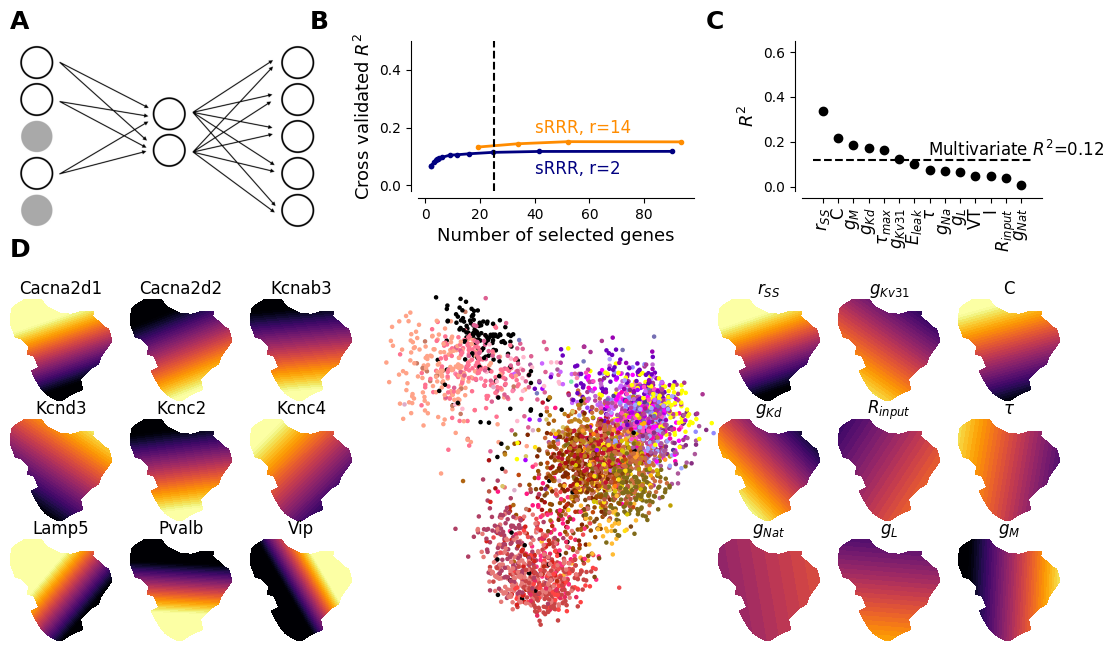

In [35]:
fig = plt.figure(figsize=(12, 6))

(
    ax_sRRR_schema,
    ax_sRRR_cv,
    ax_sRRR_pred,
    ax_sRRR_latent,
    ax_sRRR_genes,
    ax_sRRR_model_params,
) = create_figure_6(fig)

img_file = os.listdir("../sRRR_sketch/")[0]
img = mpimg.imread("../sRRR_sketch/" + img_file)

ax_sRRR_schema.imshow(img)
ax_sRRR_schema.set_xticks([])
ax_sRRR_schema.set_yticks([])
sns.despine(ax=ax_sRRR_schema, left=True, bottom=True)

dims_to_show = [2, 5, 6, 12]

ax_sRRR_cv.plot(n_2, cr_2, ".-", linewidth=2, color="navy")
ax_sRRR_cv.plot(n_14[1:], cr_14[1:], ".-", linewidth=2, color="darkorange")
ax_sRRR_cv.set_ylim([-0.02, 0.5])
ax_sRRR_cv.set_xlabel("Number of selected genes", fontsize=13)
ax_sRRR_cv.set_ylabel(r"Cross validated $R^2$", fontsize=13)
ax_sRRR_cv.vlines(
    x=25,
    ymin=ax_sRRR_cv.get_ylim()[0],
    ymax=ax_sRRR_cv.get_ylim()[1],
    linestyles="dashed",
    color="black",
)
ax_sRRR_cv.annotate(
    "sRRR, r=14", (40, np.max(cr_14) + 0.03), fontsize=12, color="darkorange"
)
ax_sRRR_cv.annotate("sRRR, r=2", (40, np.max(cr_2) - 0.08), fontsize=12, color="navy")

adjust_spines(ax_sRRR_cv, ["bottom", "left"])

order = np.argsort(sRRR_2_ind_score)[::-1]
ax_sRRR_pred.scatter(
    range(len(model_param_names)), sRRR_2_ind_score[order], color="black"
)
ax_sRRR_pred.hlines(
    sRRR_2_multivar_score,
    xmin=ax_sRRR_pred.get_xlim()[0],
    xmax=ax_sRRR_pred.get_xlim()[1],
    linestyle="dashed",
    color="black",
)
ax_sRRR_pred.annotate(
    r"Multivariate $R^2$={0:.2f}".format(sRRR_2_multivar_score),
    (
        ax_sRRR_pred.get_xlim()[0]
        + 1.05 * (ax_sRRR_pred.get_xlim()[1] - ax_sRRR_pred.get_xlim()[0]) / 2,
        sRRR_2_multivar_score + 0.02,
    ),
    fontsize=12,
)
ax_sRRR_pred.set_ylim([-0.02, 0.65])
ax_sRRR_pred.set_ylabel(r"$R^2$", fontsize=13)
ax_sRRR_pred.set_xticks(range(len(model_param_names)))
adjust_spines(ax_sRRR_pred, ["bottom", "left"])
ax_sRRR_pred.set_xticklabels(model_param_names[order], rotation=90, fontsize=12)


ax_sRRR_latent.scatter((G @ w)[:, 1], (G @ w)[:, 0], s=5, c=colors[non_nans])
ax_sRRR_latent.set_xticks([])
ax_sRRR_latent.set_yticks([])
sns.despine(ax=ax_sRRR_latent, left=True, bottom=True)

gene_indices_for_visualization = [2, 3, 9, 12, 10, 11, 17, 19, 24]

for i, ax in enumerate(ax_sRRR_genes.reshape(-1)):
    latent_space_genes_sRRR(
        G, w, gene_indices_for_visualization[i], gene_names, axis=ax
    )
    sns.despine(ax=ax, left=True, bottom=True)

model_param_names_indices_for_visualization = [-2, 7, 0, 5, 1, 2, 3, 8, 6]

for i, ax in enumerate(ax_sRRR_model_params.reshape(-1)):
    latent_space_ephys_sRRR(
        G,
        w,
        v,
        model_param_names_indices_for_visualization[i],
        model_param_names,
        axis=ax,
    )
    sns.despine(ax=ax, left=True, bottom=True)

fig.text(0, 1.02, "A", fontsize=18, fontweight="bold")
fig.text(0.25, 1.02, "B", fontsize=18, fontweight="bold")
fig.text(0.58, 1.02, "C", fontsize=18, fontweight="bold")
fig.text(0, 0.64, "D", fontsize=18, fontweight="bold")

plt.savefig("figure_6_V1.png", bbox_inches="tight", pad_inches=0)
plt.savefig("figure_6_V1.pdf", bbox_inches="tight", pad_inches=0)

In [37]:
def create_figure_7(fig):
    if fig is None:
        fig = plt.figure(figsize=(12, 5))
    else:
        fig = fig

    ax_df_npen_fam = plt.axes([0.05, 0.5, 0.08, 0.41])
    ax_df_npen_ttype = plt.axes([0.15, 0.5, 0.85, 0.41])
    ax_df_sRRR_fam = plt.axes([0.05, 0, 0.08, 0.41])
    ax_df_sRRR_ttype = plt.axes([0.15, 0, 0.85, 0.41])

    return ax_df_npen_fam, ax_df_npen_ttype, ax_df_sRRR_fam, ax_df_sRRR_ttype

Let us insert spaces between cell types.

In [38]:
df_ttype_c = df_ttype.copy()
df_ttype_sRRR_c = df_ttype_sRRR.copy()
spots_to_insert_blanks = [7, 12, 29, 43, 52,63]
for i in [7, 12, 29, 43, 52,63]:
    df_ttype_c.insert(i, i, 0)
    df_ttype_sRRR_c.insert(i, i, 0)
mask = np.zeros_like(df_ttype_c.values, dtype=bool)
mask[:, spots_to_insert_blanks] = True

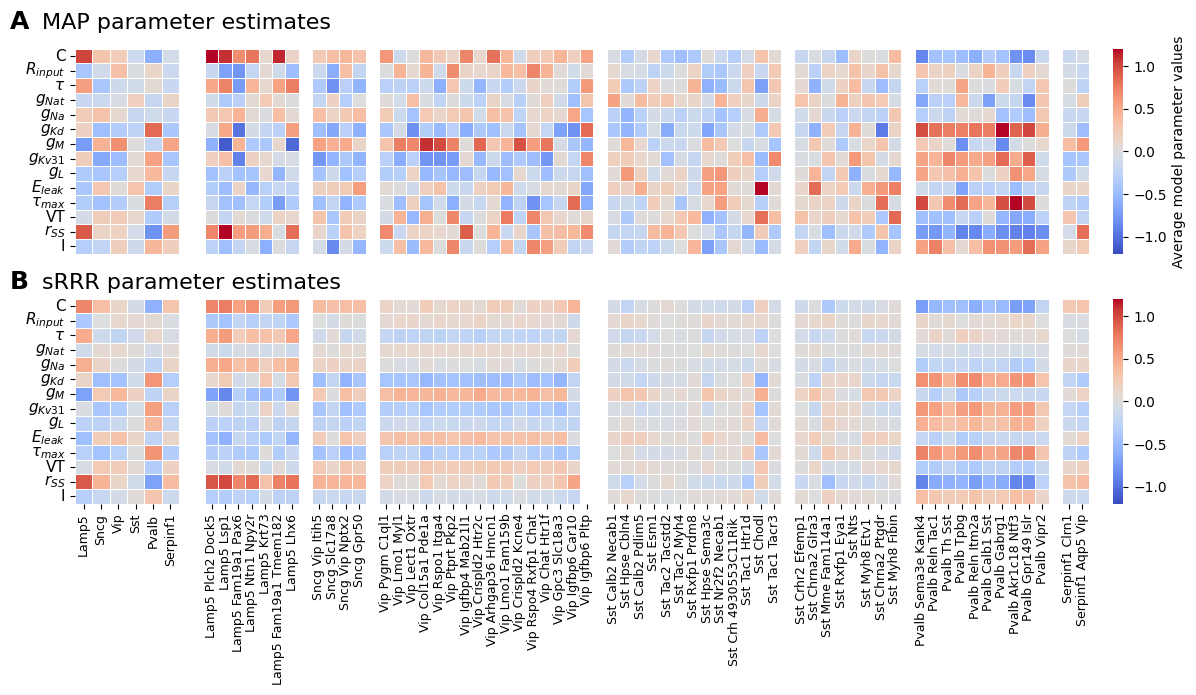

In [40]:
fig = plt.figure(figsize=(13, 5))

ax_df_npen_fam, ax_df_npen_ttype, ax_df_sRRR_fam, ax_df_sRRR_ttype = create_figure_7(
    fig
)

sns.heatmap(
    df_family,
    xticklabels=True,
    yticklabels=model_param_names,
    linewidth=0.5,
    vmin=-1.2,
    vmax=1.2,
    cbar=False,
    cmap='coolwarm',
    ax=ax_df_npen_fam,
)
sns.heatmap(
    df_ttype_c,
    mask=mask,
    xticklabels=True,
    linewidth=0.5,
    yticklabels=[],
    vmin=-1.2,
    vmax=1.2,
    ax=ax_df_npen_ttype,
    cmap='coolwarm',
    cbar_kws={"label": "Average model parameter from genes", "anchor": (-0.2, 0.5)},
)
ax_df_npen_ttype.set_xticks([])
ax_df_npen_fam.set_xticks([])
ax_df_npen_fam.set_yticks(
    [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5]
)
ax_df_npen_fam.set_yticklabels(model_param_names, fontsize=11)
ax_df_npen_ttype.collections[0].colorbar.set_label(
    "Average model parameter values", fontsize=10
)

sns.heatmap(
    df_family_sRRR,
    xticklabels=True,
    linewidth=0.5,
    yticklabels=model_param_names,
    vmin=-1.2,
    vmax=1.2,
    cmap='coolwarm',
    cbar=False,
    ax=ax_df_sRRR_fam,
)
sns.heatmap(
    df_ttype_sRRR_c,
    mask=mask,
    xticklabels=True,
    linewidth=0.5,
    yticklabels=[],
    vmin=-1.2,
    vmax=1.2,
    ax=ax_df_sRRR_ttype,
    cmap='coolwarm',
    cbar_kws={"anchor": (-0.2, 0.5)},
)
ax_df_sRRR_fam.set_xticklabels(
    ax_df_sRRR_fam.get_xticklabels(), fontsize=9, rotation=90
)
ax_df_sRRR_ttype.set_xticklabels(
    ax_df_sRRR_ttype.get_xticklabels(), fontsize=9, rotation=90
)
ax_df_sRRR_fam.set_yticks(
    [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5, 13.5]
)
ax_df_sRRR_fam.set_yticklabels(model_param_names, fontsize=11)
ax_df_sRRR_ttype.set_xticks(
    np.delete(ax_df_sRRR_ttype.get_xticks(), [7, 12, 29, 43, 52, 63])
)

fig.text(0, 0.95, "A", fontsize=18, fontweight="bold")
fig.text(0.025, 0.95, "MAP parameter estimates", fontsize=16)#, fontweight="bold")
fig.text(0, 0.43, "B", fontsize=18, fontweight="bold")
fig.text(0.025, 0.43, "sRRR parameter estimates", fontsize=16)#, fontweight="bold")

plt.savefig("figure_7_V1.png", bbox_inches="tight", pad_inches=0)
plt.savefig("figure_7_V1.pdf", bbox_inches="tight", pad_inches=0)

Similarity between two left panels, measured by: <br>
$\frac{MSE(X-Y)}{var(X)}$

Family level:

In [44]:
variance = (
    1
    / (df_family.values.reshape(-1).shape[0] - 1)
    * np.sum(
        (df_family.values.reshape(-1) - np.mean(df_family.values.reshape(-1))) ** 2
    )
)
mse = np.sum((df_family.values - df_family_sRRR.values) ** 2)
mse / variance

14.868186110999533

Cell type level, Pvalb:

In [45]:
variance = (
    1
    / (
        df_ttype_c.loc[:, np.unique(celltypes[celltype_Pvalb])]
        .values.reshape(-1)
        .shape[0]
        - 1
    )
    * np.sum(
        (
            df_ttype_c.loc[:, np.unique(celltypes[celltype_Pvalb])].values.reshape(-1)
            - np.mean(
                df_ttype_c.loc[:, np.unique(celltypes[celltype_Pvalb])].values.reshape(
                    -1
                )
            )
        )
        ** 2
    )
)
mse = np.sum(
    (
        df_ttype_c.loc[:, np.unique(celltypes[celltype_Pvalb])].values
        - df_ttype_sRRR_c.loc[:, np.unique(celltypes[celltype_Pvalb])].values
    )
    ** 2
)
mse / variance

33.60850766982343

Cell type level, Lamp5:

In [46]:
variance = (
    1
    / (
        df_ttype_c.loc[:, np.unique(celltypes[celltype_Lamp5])]
        .values.reshape(-1)
        .shape[0]
        - 1
    )
    * np.sum(
        (
            df_ttype_c.loc[:, np.unique(celltypes[celltype_Lamp5])].values.reshape(-1)
            - np.mean(
                df_ttype_c.loc[:, np.unique(celltypes[celltype_Lamp5])].values.reshape(
                    -1
                )
            )
        )
        ** 2
    )
)
mse = np.sum(
    (
        df_ttype_c.loc[:, np.unique(celltypes[celltype_Lamp5])].values
        - df_ttype_sRRR_c.loc[:, np.unique(celltypes[celltype_Lamp5])].values
    )
    ** 2
)
mse / variance

35.35934902813751

Cell type level, Vip:

For one specific Vip celltype, we seem to have Nans for average model parameters, so the result here is Nan:

In [47]:
variance = (
    1
    / (
        df_ttype_c.loc[:, np.unique(celltypes[celltype_Vip])]
        .values.reshape(-1)
        .shape[0]
        - 1
    )
    * np.sum(
        (
            df_ttype_c.loc[:, np.unique(celltypes[celltype_Vip])].values.reshape(-1)
            - np.mean(
                df_ttype_c.loc[:, np.unique(celltypes[celltype_Vip])].values.reshape(-1)
            )
        )
        ** 2
    )
)
mse = np.sum(
    (
        df_ttype_c.loc[:, np.unique(celltypes[celltype_Vip])].values
        - df_ttype_sRRR_c.loc[:, np.unique(celltypes[celltype_Vip])].values
    )
    ** 2
)
mse / variance

nan

Cell type level, Sst:

In [49]:
variance = (
    1
    / (
        df_ttype_c.loc[:, np.unique(celltypes[celltype_Vip])]
        .values.reshape(-1)
        .shape[0]
        - 1
    )
    * np.sum(
        (
            df_ttype_c.loc[:, np.unique(celltypes[celltype_Sst])].values.reshape(-1)
            - np.mean(
                df_ttype_c.loc[:, np.unique(celltypes[celltype_Sst])].values.reshape(-1)
            )
        )
        ** 2
    )
)
mse = np.sum(
    (
        df_ttype_c.loc[:, np.unique(celltypes[celltype_Sst])].values
        - df_ttype_sRRR_c.loc[:, np.unique(celltypes[celltype_Sst])].values
    )
    ** 2
)
mse / variance

172.8585788052422

Cell type level, Serpinf1:

In [51]:
variance = (
    1
    / (
        df_ttype_c.loc[:, np.unique(celltypes[celltype_Serpinf1])]
        .values.reshape(-1)
        .shape[0]
        - 1
    )
    * np.sum(
        (
            df_ttype_c.loc[:, np.unique(celltypes[celltype_Serpinf1])].values.reshape(-1)
            - np.mean(
                df_ttype_c.loc[:, np.unique(celltypes[celltype_Serpinf1])].values.reshape(-1)
            )
        )
        ** 2
    )
)
mse = np.sum(
    (
        df_ttype_c.loc[:, np.unique(celltypes[celltype_Serpinf1])].values
        - df_ttype_sRRR_c.loc[:, np.unique(celltypes[celltype_Serpinf1])].values
    )
    ** 2
)
mse / variance

19.312909860652614

Cell type level, Sncg:

In [52]:
variance = (
    1
    / (
        df_ttype_c.loc[:, np.unique(celltypes[celltype_Sncg])]
        .values.reshape(-1)
        .shape[0]
        - 1
    )
    * np.sum(
        (
            df_ttype_c.loc[:, np.unique(celltypes[celltype_Sncg])].values.reshape(-1)
            - np.mean(
                df_ttype_c.loc[:, np.unique(celltypes[celltype_Sncg])].values.reshape(
                    -1
                )
            )
        )
        ** 2
    )
)
mse = np.sum(
    (
        df_ttype_c.loc[:, np.unique(celltypes[celltype_Sncg])].values
        - df_ttype_sRRR_c.loc[:, np.unique(celltypes[celltype_Sncg])].values
    )
    ** 2
)
mse / variance

29.792063154500944